In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.linear_model import LinearRegression
import plotly.express as px
from sklearn.metrics import mean_absolute_error

In [100]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    split_df = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";",expand=True)
    df[["sensor_id","sensor_type","location","lat","lon","timestamp","value_type","value"]] = split_df
    df = df.drop(columns=["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"])
    df[["lat","lon","value"]] = df[["lat","lon","value"]].astype(float)
    new_df = df[["timestamp","value_type","value"]][df[["timestamp","value_type","value"]]["value_type"] == "P2"].drop(columns=["value_type"])
    new_df = new_df[new_df['value'] < 30]
    new_df["timestamp"] = pd.to_datetime(new_df["timestamp"])
    new_df = new_df.set_index("timestamp")
    new_df.index = new_df.index.tz_convert("Africa/Nairobi")
    new_dfs = new_df["value"].resample("10T").mean().fillna(method="ffill").to_frame()
    new_dfs["value_2"] = new_dfs["value"].shift(1)
    new_dfs = new_dfs.dropna()
    return new_dfs
    

In [101]:
df = wrangle("November_2018_sensor_data_archive.csv")

In [103]:
len(df)

943

In [76]:
# fig,ax = plt.subplots(figsize=(10,6))
# plot_pacf(df,ax=ax)
# plt.xlabel("Lag values");

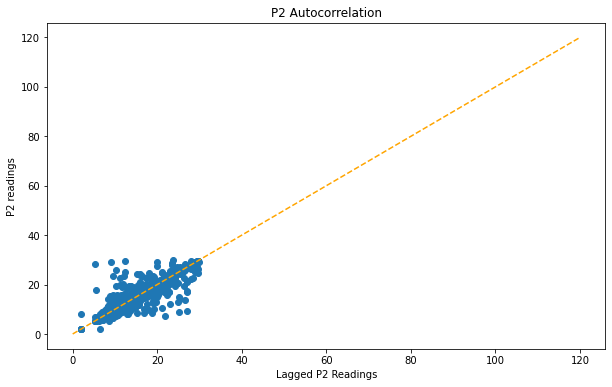

In [104]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(x=df["value_2"],y=df["value"])
ax.plot([0,120],[0,120], linestyle="--",color="orange")
plt.xlabel("Lagged P2 Readings")
plt.ylabel("P2 readings")
plt.title("P2 Autocorrelation");

In [79]:
#Splitting into X,y

In [105]:
X = df.drop(columns=["value"])
y = df["value"]

In [106]:
cut_off = int(len(df) * 0.8)
X_train, y_train = X.iloc[:cut_off] , y.iloc[:cut_off]
X_test , y_test = X.iloc[cut_off:], y.iloc[cut_off:]

In [107]:
len(X) == len(X_train) + len(X_test)

True

In [108]:
len(X_train)

754

In [111]:
model = LinearRegression()

In [112]:
#Baseline_model

In [124]:
X_train_mean = X_train['value_2'].mean()
baseline = len(X_train) * [X_train_mean]
baseline_mae = mean_absolute_error(y_train,baseline)
print(f" mean value for X_train = {X_train_mean}")
print(f" baseline_mae = {baseline_mae}")


 mean value for X_train = 13.965446064551518
 baseline_mae = 4.5646838452285845


In [125]:
model.fit(X_train,y_train)

LinearRegression()

In [126]:
train_pred = model.predict(X_train)

In [127]:
train_pred_mae = mean_absolute_error(train_pred,y_train)

In [128]:
print(f"train_pred_mae = {train_pred_mae}")

train_pred_mae = 1.646375417356657


In [130]:
test_pred = model.predict(X_test)

In [131]:
test_pred_mae = mean_absolute_error(test_pred,y_test)

In [132]:
print(f"test_pred_mae = {test_pred_mae}")

test_pred_mae = 1.8189957563325967


In [133]:
results = pd.DataFrame(
    {"y_test":y_test,"test_pred":test_pred}
)

In [134]:
results.head()

,y_test,test_pred
timestamp,,
2018-11-29 19:30:00+03:00,7.525294,11.097767
2018-11-29 19:40:00+03:00,9.334375,8.272220
2018-11-29 19:50:00+03:00,9.590000,9.872256
2018-11-29 20:00:00+03:00,9.691579,10.098342
2018-11-29 20:10:00+03:00,9.638000,10.188184


In [139]:
px.line(results,labels ={"values":"P2"})